In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as signal
from pathlib import Path
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import sosfiltfilt, butter
from hmmlearn import hmm


import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple, name_data
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle
from filters import filter_butter

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [2]:
''' Alterar o número do Voluntário e a Chave de Repetição'''

voluntary = 1
key = 'S1_Synched'

voluntary = str(voluntary)


''' Alterar o número do Voluntário Referência e a Chave de Repetição Referência'''

ref_voluntary = 52
ref_key = 'S1_Synched'

ref_voluntary = str(ref_voluntary)


In [3]:
archive, name, sincro = name_data(voluntary, key)
ref_archive, ref_name, ref_sincro = name_data(ref_voluntary, ref_key)
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

data = pd.read_csv(data_path + archive, sep = ';')
ref_data = pd.read_csv(data_path + ref_archive, sep = ';')

In [4]:
RightUpLeg = data.iloc[:,3:6].values
LeftUpLeg = data.iloc[:,6:9].values
Spine = data.iloc[:,15:18].values
R_0 = ref_data.iloc[:,3:6].values
L_0 = ref_data.iloc[:,6:9].values
S_0 = ref_data.iloc[:,15:18].values

In [5]:
# Definindo a frequência de amostragem
freq_amostragem = 120

# Definindo a ordem do filtro 
ordem = 2

# Definindo frequência de corte do filtro 
freq_corte_Leg = 0.7
freq_corte_Spine = 1.3

In [6]:
# Aplicando filtro com frequência de corte do pescoço, perna direita e perna esquerda.
Spine_filter = filter_butter(Spine, ordem, freq_corte_Spine, freq_amostragem)
RightUpLeg_filter = filter_butter(RightUpLeg, ordem, freq_corte_Leg, freq_amostragem)
LeftUpLeg_filter = filter_butter(LeftUpLeg, ordem, freq_corte_Leg, freq_amostragem)
S_0_filter = filter_butter(S_0, ordem, freq_corte_Spine, freq_amostragem)
R_0_filter = filter_butter(R_0, ordem, freq_corte_Leg, freq_amostragem)
L_0_filter = filter_butter(L_0, ordem, freq_corte_Leg, freq_amostragem)

# Aplicando as transformações de aceleração para os dados de ângulos
angle_rad_Spine_filter, angle_Spine_filter = acc_to_angle(Spine_filter)
angle_rad_RightUpLeg_filter, angle_RightUpLeg_filter = acc_to_angle(RightUpLeg_filter)
angle_rad_LeftUpLeg_filter, angle_LeftUpLeg_filter = acc_to_angle(LeftUpLeg_filter)
angle_rad_Spine_filter, angle_S_0_filter = acc_to_angle(S_0_filter)
angle_rad_RightUpLeg_filter, angle_R_0_filter = acc_to_angle(R_0_filter)
angle_rad_LeftUpLeg_filter, angle_L_0_filter = acc_to_angle(L_0_filter)


# Criando vetor de tempo
t = np.linspace(0, len(angle_RightUpLeg_filter) / freq_amostragem, len(angle_RightUpLeg_filter))

# Criando título das imagens
title_Spine = 'Filtro em ' + str(freq_corte_Spine) + 'Hz'
title_Leg = 'Filtro em ' + str(freq_corte_Leg) + 'Hz'

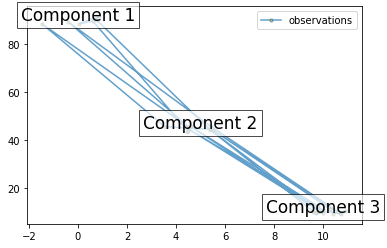

In [7]:
startprob = np.array([0.7, 0.0, 0.3])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.6, 0.4, 0.0],
                     [0.4, 0.2, 0.4],
                     [0.0, 0.4, 0.6],])
# The means of each component
means = np.array([[0.0,  90.0],
                  [5.0, 45.0],
                  [10.0, 10.0],])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (3, 1, 1))

# Build an HMM instance and set parameters
model = hmm.GaussianHMM(n_components=3, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars
###############################################################

# Generate samples
X, Z = model.sample(30)

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=6,
         mfc="orange", alpha=0.7)

# Indicate the component numbers
for i, m in enumerate(means):
    plt.text(m[0], m[1], 'Component %i' % (i + 1),
             size=17, horizontalalignment='center',
             bbox=dict(alpha=.7, facecolor='w'))
plt.legend(loc='best')
plt.show()

In [8]:
X = np.concatenate([angle_Spine_filter, angle_RightUpLeg_filter])
Y = np.concatenate([angle_Spine_filter, angle_LeftUpLeg_filter])
lengths = [len(angle_Spine_filter), len(angle_RightUpLeg_filter)]
f=int(len(X)/2)

In [9]:
Y = Y/max(Y)

In [10]:
predict = np.zeros([Y.shape[0],2])
#predict = np.zeros([X.shape[0],1])

In [11]:
predict[:,0] = X[:,0]

In [12]:
predict[0:140,1] = 0
predict[140:370,1] = 1
predict[370:570,1] = 2
predict[570:865,1] = 1
predict[865:f,1] = 0
predict[f:1013,1] = 0
predict[1013:1243,1] = 1
predict[1243:1443,1] = 2
predict[1443:1738,1] = 1
predict[1738:,1] = 0

In [13]:
f

893

In [14]:
remodel = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100).fit(predict, lengths)
Z2 = remodel.predict(predict)

In [15]:
remodel.monitor_

ConvergenceMonitor(
    history=[-9887.961576657908, -8145.1834369016215, -6573.928143818906, -4058.729623198936, -572.0813276225257, 1045.6299246617552, 1045.6299246617557],
    iter=7,
    n_iter=100,
    tol=0.01,
    verbose=False,
)

In [16]:
#remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)

In [17]:
#remodel.fit(predict)

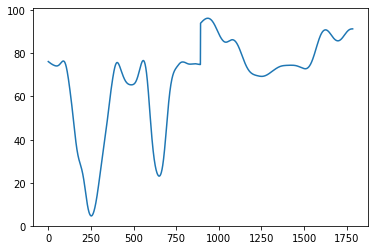

In [18]:
plt.plot(X)

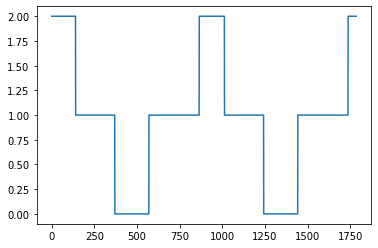

In [19]:
plt.plot(Z2)

In [20]:
k=f

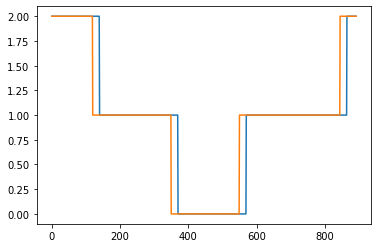

In [21]:
plt.plot(Z2[:k])
plt.plot(Z2[k:])

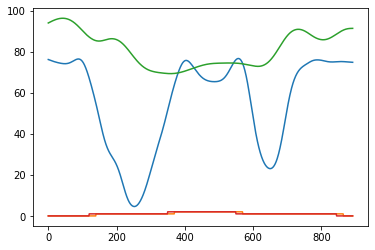

In [22]:
plt.plot(predict[:f])
plt.plot(predict[f:])

In [23]:
W = remodel.decode(predict, algorithm='viterbi')

In [24]:
W

(1045.6239186376756, array([2, 2, 2, ..., 2, 2, 2]))

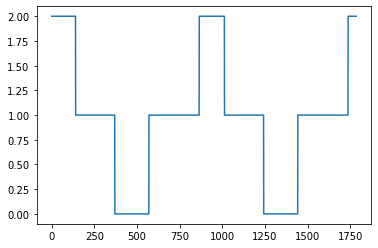

In [25]:
plt.plot(W[1])
#plt.plot(Z2)

In [26]:
remodel.transmat_

array([[0.995     , 0.005     , 0.        ],
       [0.00190476, 0.99619048, 0.00190476],
       [0.        , 0.00598802, 0.99401198]])

In [27]:
remodel.startprob_

array([0., 0., 1.])

In [28]:
remodel.means_

array([[71.38314431,  2.        ],
       [62.65909385,  1.        ],
       [82.93834394,  0.        ]])

In [29]:
remodel.covars_

array([[[1.12092260e+01, 2.50000000e-05],
        [2.50000000e-05, 2.50000000e-05]],

       [[6.35573922e+02, 9.52380952e-06],
        [9.52380952e-06, 9.52380952e-06]],

       [[1.12362460e+02, 2.97619048e-05],
        [2.97619048e-05, 2.97619048e-05]]])